In [1]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
from adl.debugger import Debugger
from agent import Agent
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
from adl.kit import animate, interact

In [4]:
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=41) # resets an environment with a seed

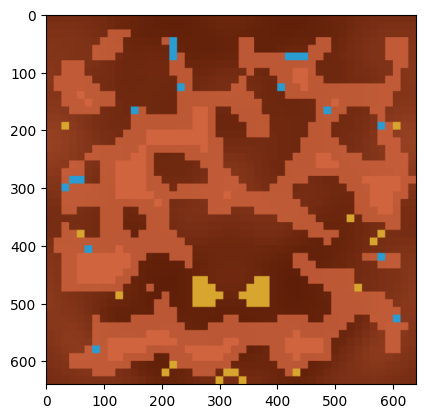

In [5]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [6]:
# for seed in range(41, 45):
#     obs = env.reset(seed=seed) # resets an environment with a seed
#     img = env.render("rgb_array", width=640, height=640)
#     plt.figure()
#     plt.imshow(img)

In [7]:
game_state = obs_to_game_state(0, env.state.env_cfg, obs["player_0"])

In [8]:

from sklearn import metrics
from scipy.spatial.distance import cdist

In [9]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

In [10]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

X = np.argwhere(game_state.board.ice == 1)

maxFactories = 8
maxK = min(int(np.sum(game_state.board.ice)), maxFactories)
K = range(1, maxK+1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_



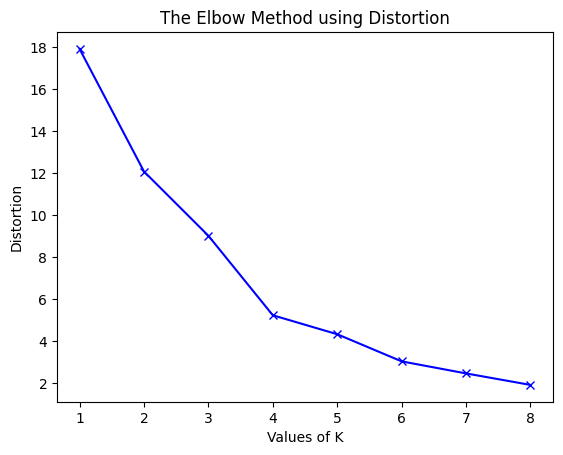

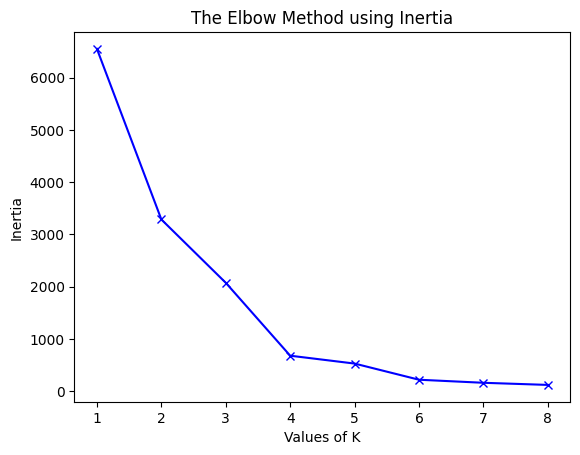

In [11]:
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# for key, val in mapping2.items():
#     print(f'{key} : {val}')
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [12]:
from adl.stats import MapStatsManager, MapStats
from adl.visual_utils import VisualUtils
from adl.debugger import Debugger

debugger = Debugger()
mapStatsManager = MapStatsManager()

	center: (4, 21)
	ice: 5
	closest_ice: [ 4 21]
	closest_ice_distance: 0
	ore: 2
	closest_ore: [ 4 28]
	closest_ore_distance: 7
	center: (22, 38)
	ice: 1
	closest_ice: [ 6 43]
	closest_ice_distance: 21
	ore: 32
	closest_ore: [21 37]
	closest_ore_distance: 2
	center: (28, 7)
	ice: 10
	closest_ice: [30  9]
	closest_ice_distance: 4
	ore: 1
	closest_ore: [45 14]
	closest_ore_distance: 24
	center: (42, 31)
	ice: 2
	closest_ice: [43 31]
	closest_ice_distance: 1
	ore: 4
	closest_ore: [42 29]
	closest_ore_distance: 2


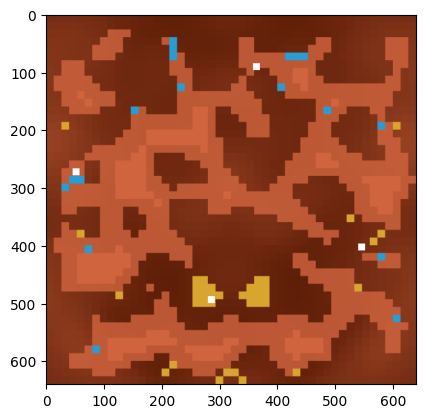

In [13]:
clusters = mapStatsManager.getResourceCluster(game_state)
debugger.printClusters(clusters)
from adl.utils import Utils
img = env.render("rgb_array", width=640, height=640)
VisualUtils.addClustersToImg(img, clusters)
plt.imshow(img)

nIceTiles: 18
nOreTiles: 39
nTotalRubble: 123565
nHighRubble: 1357
nLowRubble: 947
Ice Clusters:
 center: (4, 27)
	ice: 5
	closest_ice: [ 5 30]
	closest_ice_distance: 4
	ore: 17
	closest_ore: [ 4 28]
	closest_ore_distance: 1
	rubble: 4815
 center: (15, 6)
	ice: 5
	closest_ice: [16  5]
	closest_ice_distance: 2
	rubble: 13145
 center: (34, 8)
	ice: 6
	closest_ice: [33  5]
	closest_ice_distance: 4
	ore: 1
	closest_ore: [45 14]
	closest_ore_distance: 17
	rubble: 11551
 center: (44, 35)
	ice: 2
	closest_ice: [43 31]
	closest_ice_distance: 5
	ore: 21
	closest_ore: [40 35]
	closest_ore_distance: 4
	rubble: 8239
Ore Clusters:
 center: (21, 36)
	ice: 10
	closest_ice: [ 5 30]
	closest_ice_distance: 22
	ore: 34
	closest_ore: [21 36]
	closest_ore_distance: 0
	rubble: 13153
 center: (41, 26)
	ice: 8
	closest_ice: [43 31]
	closest_ice_distance: 7
	ore: 5
	closest_ore: [39 26]
	closest_ore_distance: 2
	rubble: 10040
Resource Clusters:
 center: (4, 21)
	ice: 5
	closest_ice: [ 4 21]
	closest_ice_distan

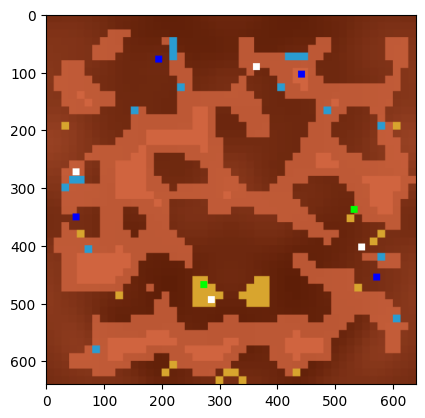

In [23]:
mapStats = mapStatsManager.collectMapStats(game_state)
img = env.render("rgb_array", width=640, height=640)
VisualUtils.addClustersToImg(img, mapStats.iceClusters, np.array([0, 0, 255]))
VisualUtils.addClustersToImg(img, mapStats.oreClusters, np.array([0, 255, 0]))
VisualUtils.addClustersToImg(img, mapStats.resourceClusters, 255)
debugger.printMapStats(mapStats)
plt.imshow(img)

In [20]:

from lux.kit import GameState, obs_to_game_state, Board
def clusterQuality(mapStat: MapStats, game_state: GameState):
    # quality is a relative one
    totalRubbleInside = 0
    totalRubbleOutside = 0
    
    